## RNA-seq DESEQ2 analysis of DMSO dataset

2 Factor design: 

* Treatment (DMSO v Control) 
* Cell Cycle (earlyG1, lateG1, SG2M) 

* 60675 genes
* 2 biological replicates per Sample (Treatment/CellCycle combination) 

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [2]:
#load ATAC-seq raw read counts
data=read.table('rsem.genes.expected_count',header=TRUE,sep='\t',stringsAsFactors = FALSE)
nrow(data)

[1] 60675

In [3]:
#concatenate ID/Gene columns values to server as rownames for the dataframe of the form ID_GENE
rownames(data)=paste(data$ID,data$GENE,sep="_")
data$ID=NULL
data$GENE=NULL
data=round(data)
head(data)

,c.earlyG1.1,c.earlyG1.2,c.lateG1.1,c.lateG1.2,c.SG2M.1,c.SG2M.2,t.earlyG1.1,t.earlyG1.2,t.lateG1.1,t.lateG1.2,t.SG2M.1,t.SG2M.2
ENSG00000000003_TSPAN6,61,73,547,32,87,174,95,131,28,48,93,81
ENSG00000000005_TNMD,0,3,1,0,4,1,4,2,0,0,1,5
ENSG00000000419_DPM1,18,33,125,5,11,18,20,17,9,14,15,22
ENSG00000000457_SCYL3,3,7,32,4,10,7,7,3,1,2,10,6
ENSG00000000460_C1orf112,28,52,318,16,67,49,63,47,15,23,70,57
ENSG00000000938_FGR,5,1,0,0,0,0,0,0,0,0,0,0


In [4]:
#load the metadata
batches=read.table("rnaseq_batches.txt",header=TRUE,sep='\t',row.names=1)
batches

,Sample,Treatment,CellCycle
c.earlyG1.1,c.earlyG1,control,earlyG1
c.earlyG1.2,c.earlyG1,control,earlyG1
c.lateG1.1,c.lateG1,control,lateG1
c.lateG1.2,c.lateG1,control,lateG1
c.SG2M.1,c.SG2M,control,SG2M
c.SG2M.2,c.SG2M,control,SG2M
t.earlyG1.1,t.earlyG1,DMSO,earlyG1
t.earlyG1.2,t.earlyG1,DMSO,earlyG1
t.lateG1.1,t.lateG1,DMSO,lateG1
t.lateG1.2,t.lateG1,DMSO,lateG1


In [5]:
batches$CellCycle=factor(batches$CellCycle)
batches$Treatment=factor(batches$Treatment)
batches$Sample=factor(batches$Sample)


In [6]:
#Create DESeq object

dds <- DESeqDataSetFromMatrix(countData = data,
                              colData = batches,
                              design = ~CellCycle + CellCycle:Treatment)


converting counts to integer mode


## Visualizations 

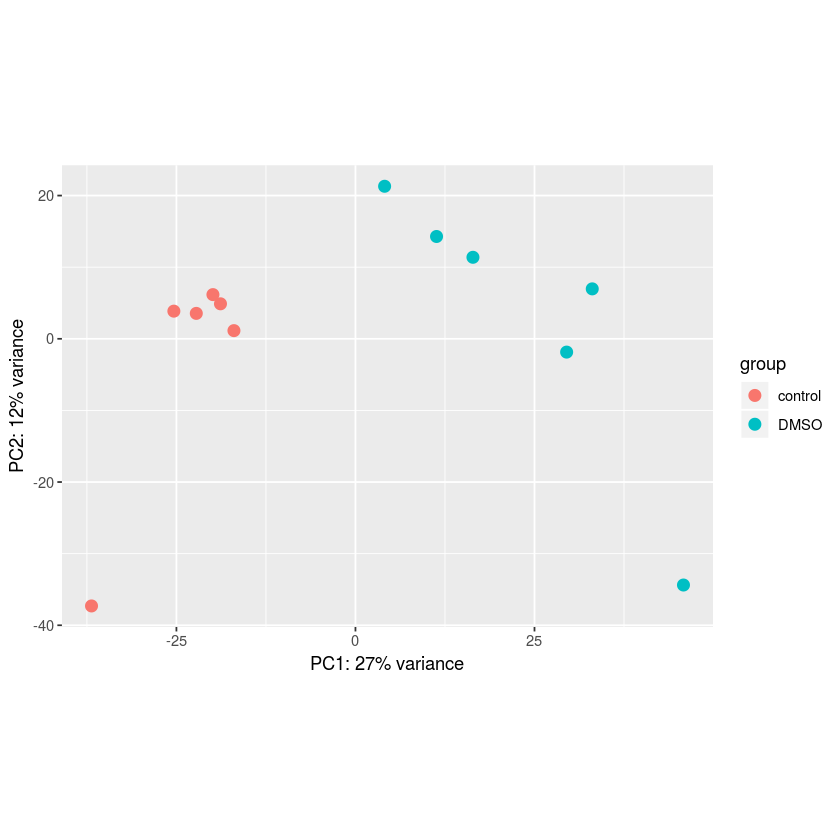

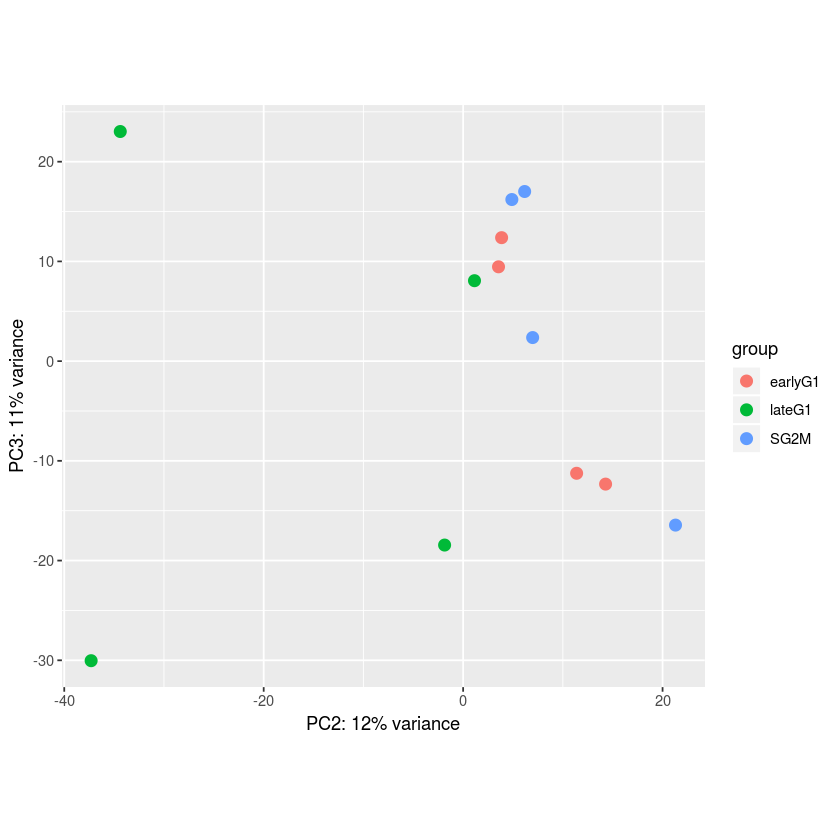

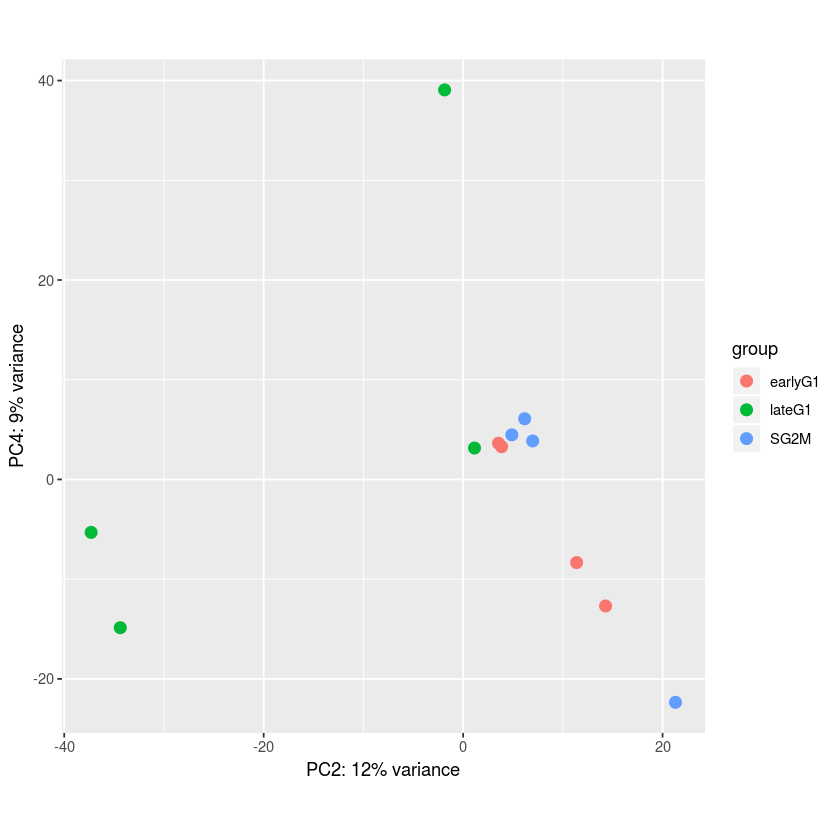

In [7]:
#PCA on vst-transformed data
vst_data=vst(dds)
source('plotPCA_custom.R')
plotPCA_custom(vst_data,intgroup=c("Treatment"),ntop=nrow(data),returnData=FALSE,pcx=1,pcy=2)
plotPCA_custom(vst_data,intgroup=c("CellCycle"),ntop=nrow(data),returnData=FALSE,pcx=2,pcy=3)
plotPCA_custom(vst_data,intgroup=c("CellCycle"),ntop=nrow(data),returnData=FALSE,pcx=2,pcy=4)

In [8]:
#perform size factor estimation for for housekeeping (HK) promoters
hk_subset=as.vector(read.table("HK_subset.txt",header=FALSE,sep='\t',stringsAsFactors = FALSE)[,1])
hk_subset_indices=match(hk_subset,rownames(data))
print(length(hk_subset_indices))

[1] 3731


In [9]:
head(hk_subset_indices)

[1]  3  4  9 22 23 33

In [10]:
dds <- estimateSizeFactors(dds, controlGenes=hk_subset_indices)


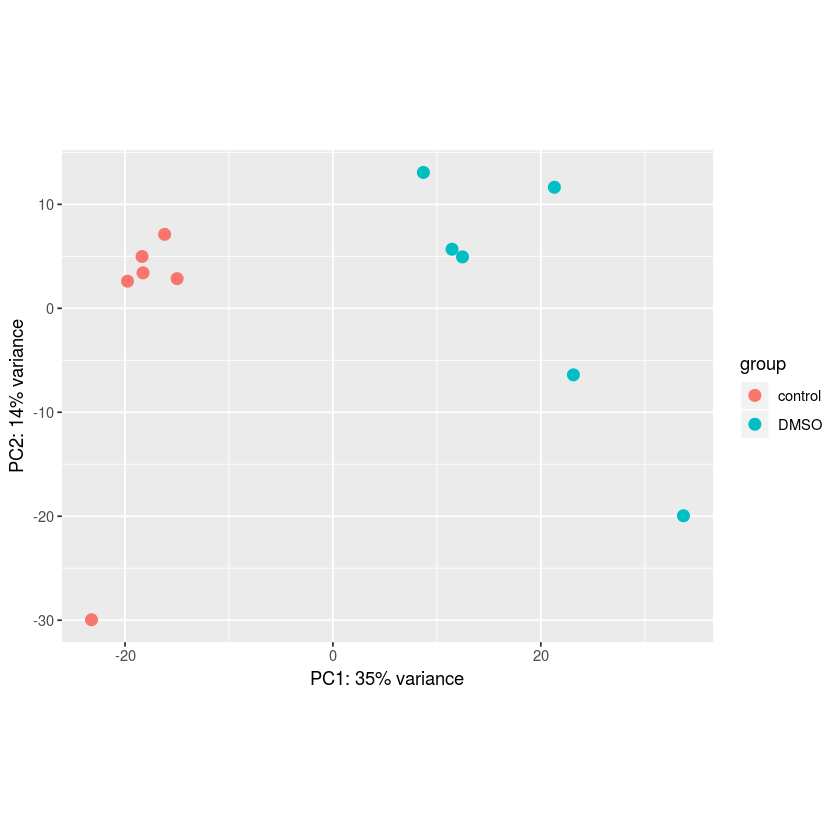

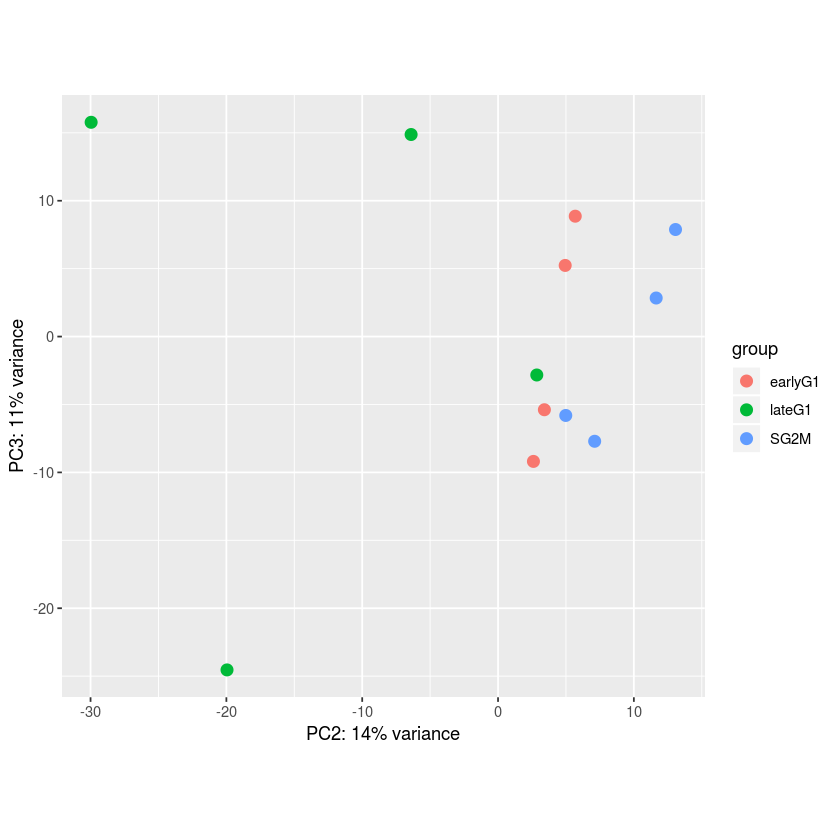

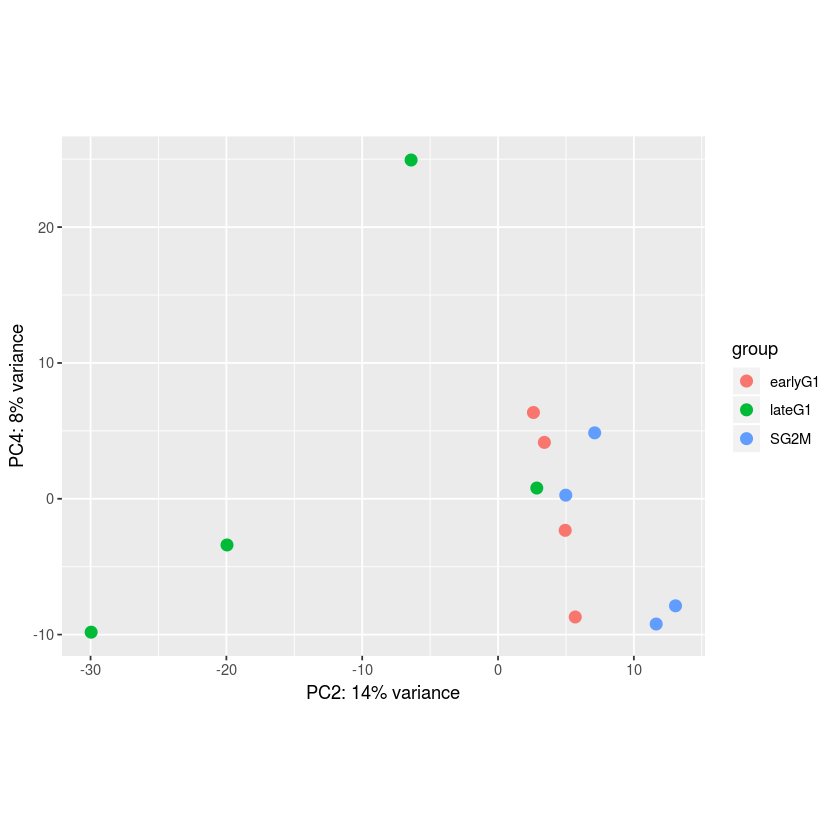

In [11]:
#PCA on vst-transformed data w/ custom sizeFactors
# shifted log of normalized counts
se <- SummarizedExperiment(log2(counts(dds, normalized=TRUE) + 1),
                           colData=colData(dds))
# the call to DESeqTransform() is needed to
# trigger our plotPCA method.
plotPCA_custom( DESeqTransform( se ),intgroup=c("Treatment"),pcx=1,pcy=2)
plotPCA_custom( DESeqTransform( se ),intgroup=c("CellCycle"),pcx=2,pcy=3)
plotPCA_custom( DESeqTransform( se ),intgroup=c("CellCycle"),pcx=2,pcy=4)

In [12]:
## Perform transformations 
vsd=vst(dds,blind=FALSE)
rld=rlog(dds,blind=FALSE)
ntd <- normTransform(dds)



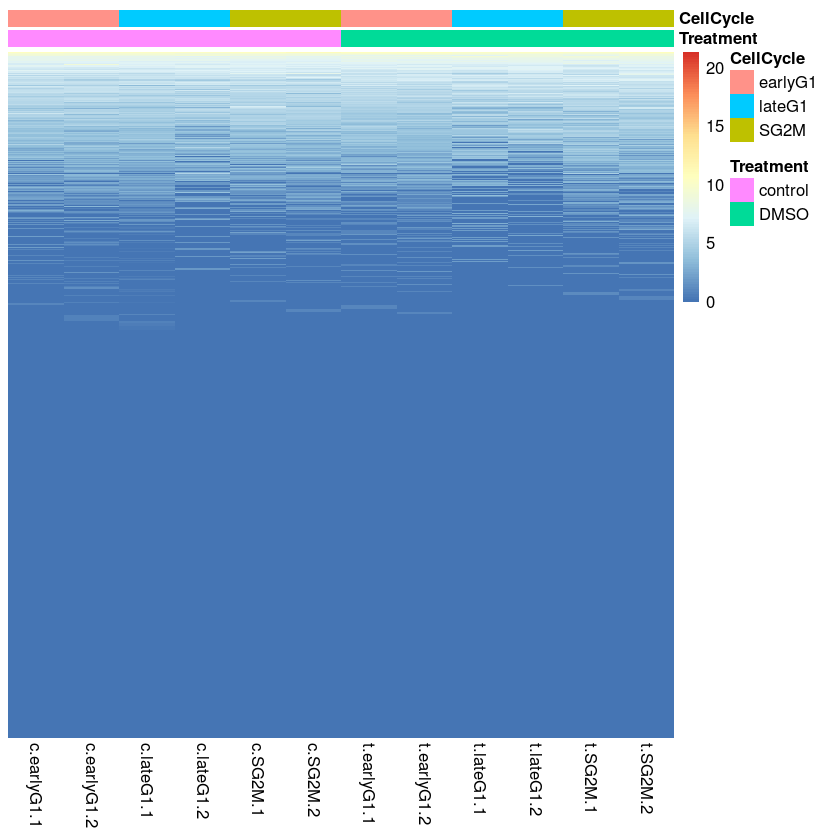

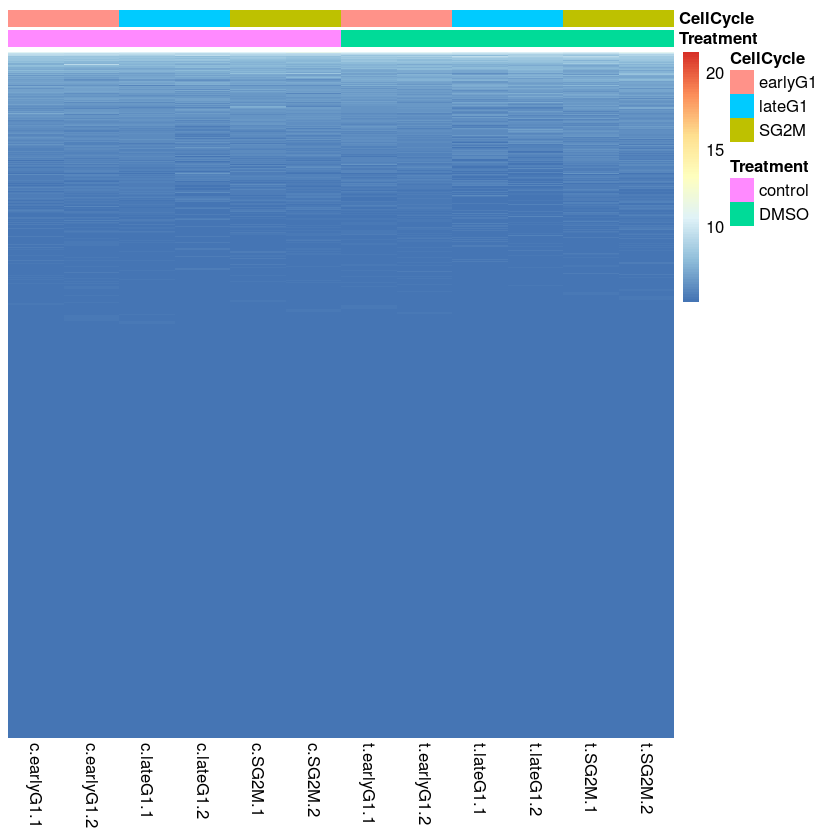

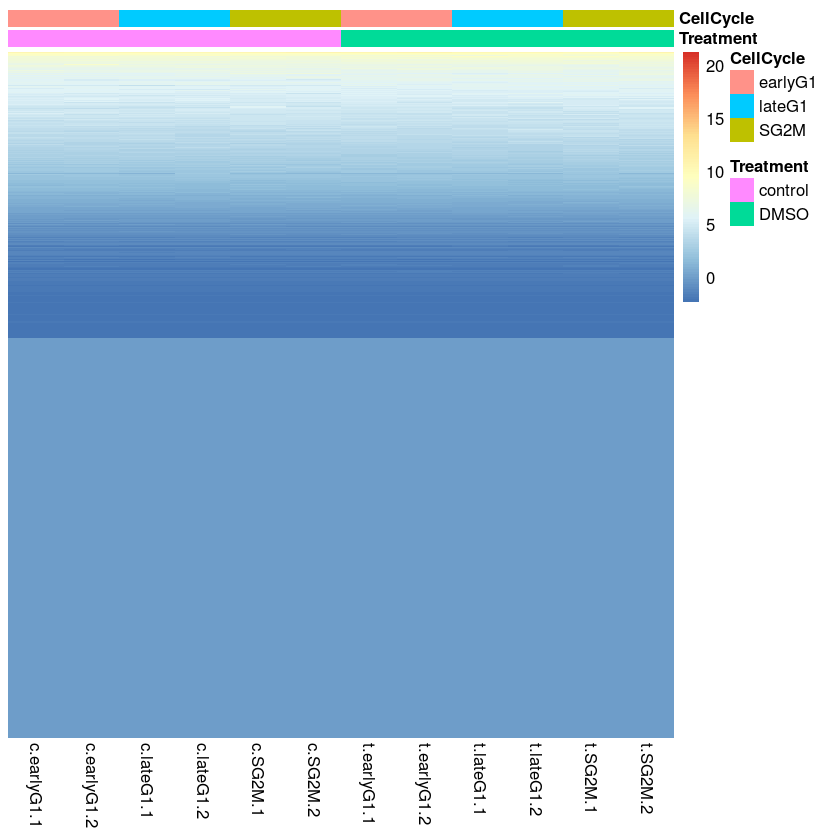

In [13]:
## Heatmap on Transformed Data 

select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)


df <- as.data.frame(colData(dds)[,c("Treatment","CellCycle")])

#log2(n + 1)
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

#VST Transform 
pheatmap(assay(vsd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

#Rlog Transform 
pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

## Differential Accessibility Operation

In [14]:
#Run the differential analysis
dds <- DESeq(dds,parallel = FALSE)


using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


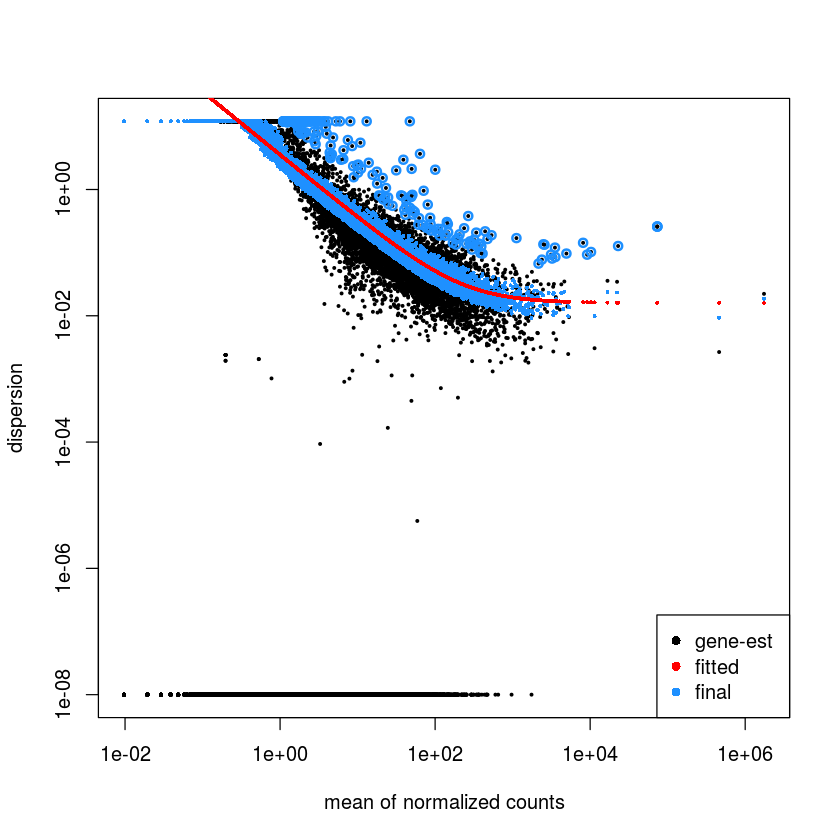

In [15]:
plotDispEsts(dds)


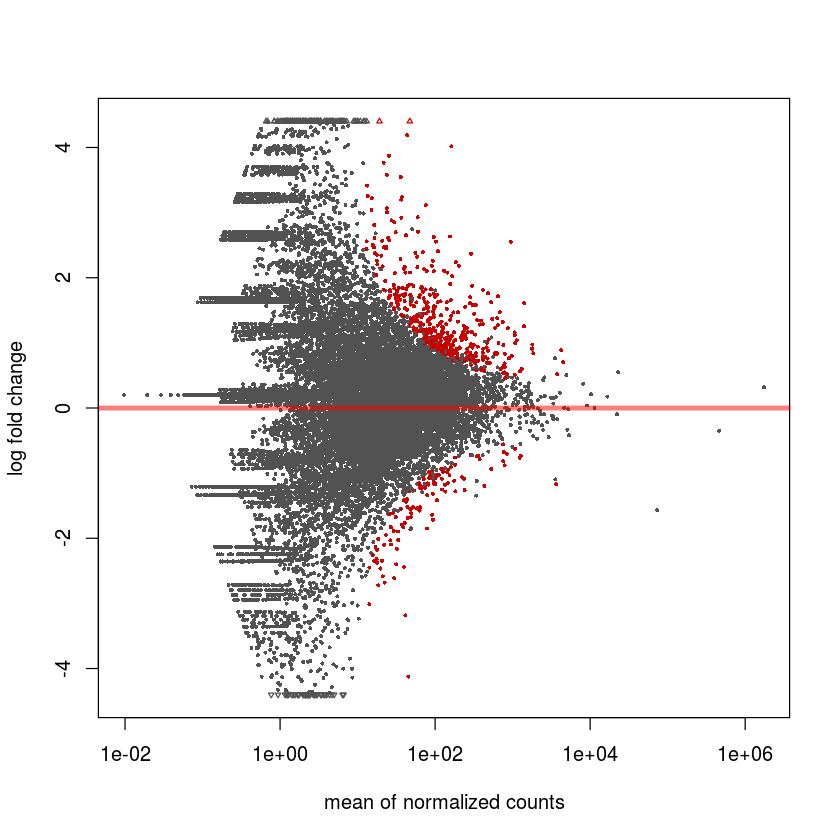

In [16]:
plotMA(dds)


## Standard BH Correction (no optimal thresholding) 

In [17]:
resultsNames(dds)

[1] "Intercept"                      "CellCycle_lateG1_vs_earlyG1"   
[3] "CellCycle_SG2M_vs_earlyG1"      "CellCycleearlyG1.TreatmentDMSO"
[5] "CellCyclelateG1.TreatmentDMSO"  "CellCycleSG2M.TreatmentDMSO"

In [18]:
res=results(dds)
summary(res)


out of 25322 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 440, 1.7%
LFC < 0 (down)     : 119, 0.47%
outliers [1]       : 0, 0%
low counts [2]     : 17284, 68%
(mean count < 13)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [19]:
namesToOutput=c("CellCycle_lateG1_vs_earlyG1",
"CellCycle_SG2M_vs_earlyG1",
"CellCycleearlyG1.TreatmentDMSO",
"CellCyclelateG1.TreatmentDMSO",
"CellCycleSG2M.TreatmentDMSO")
numcomparisons=length(namesToOutput)

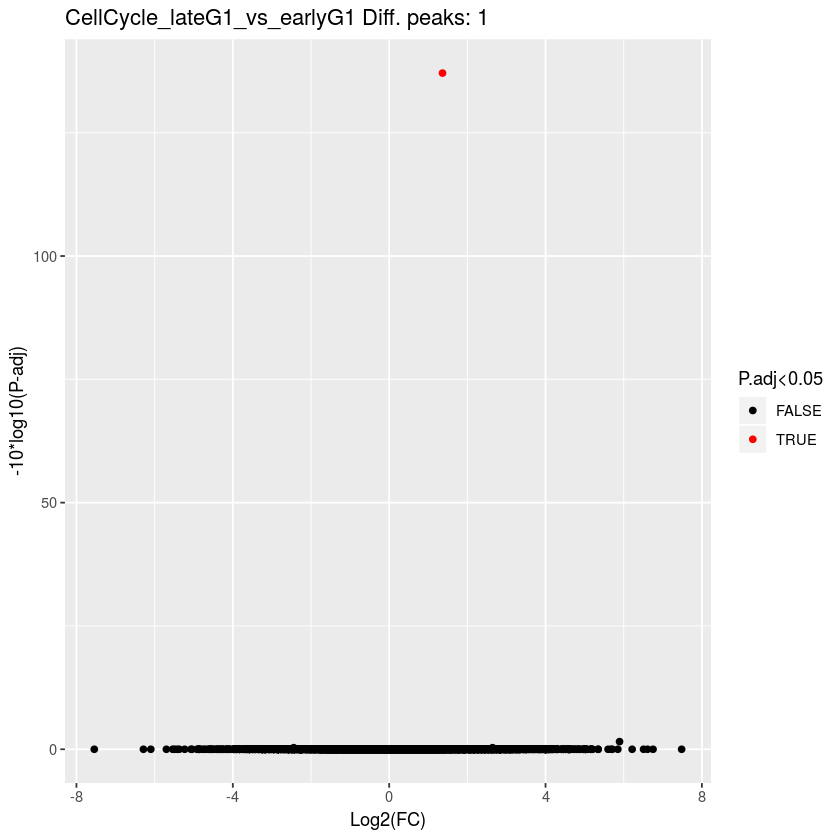

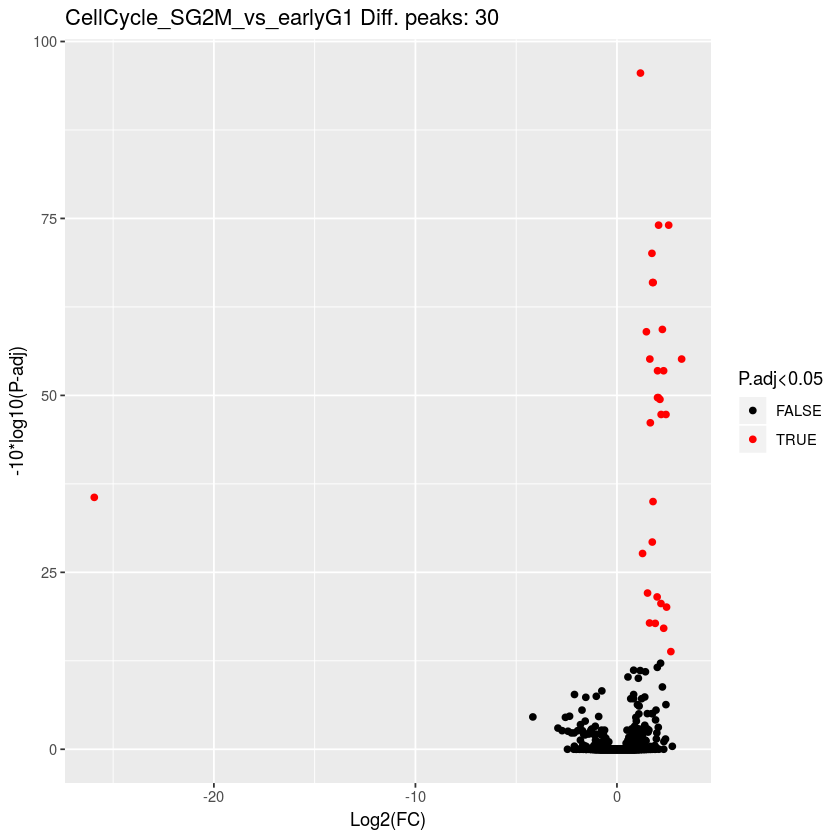

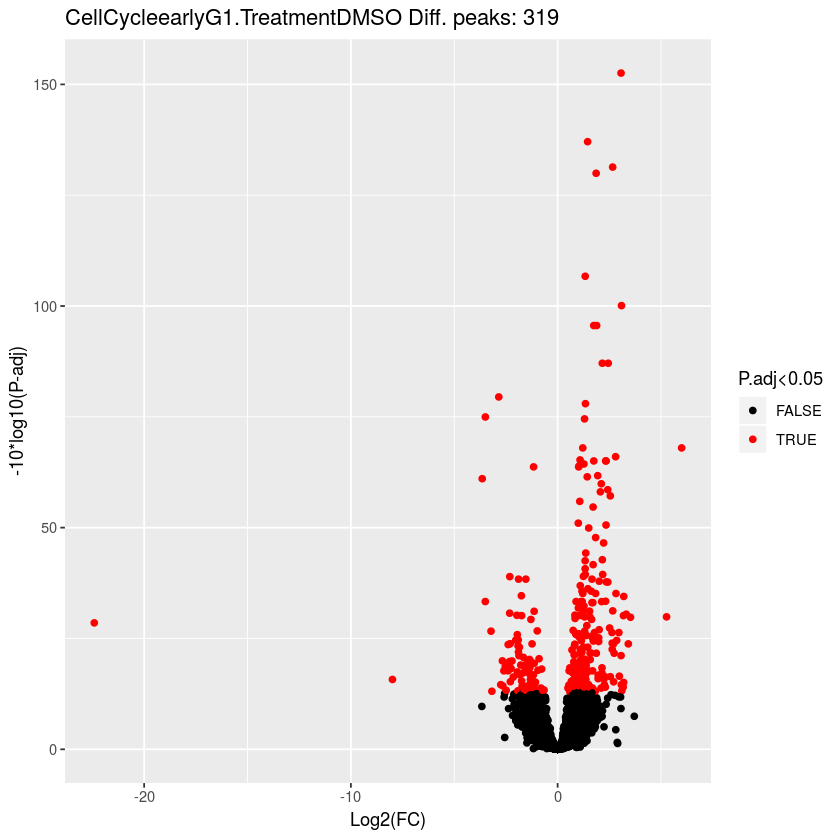

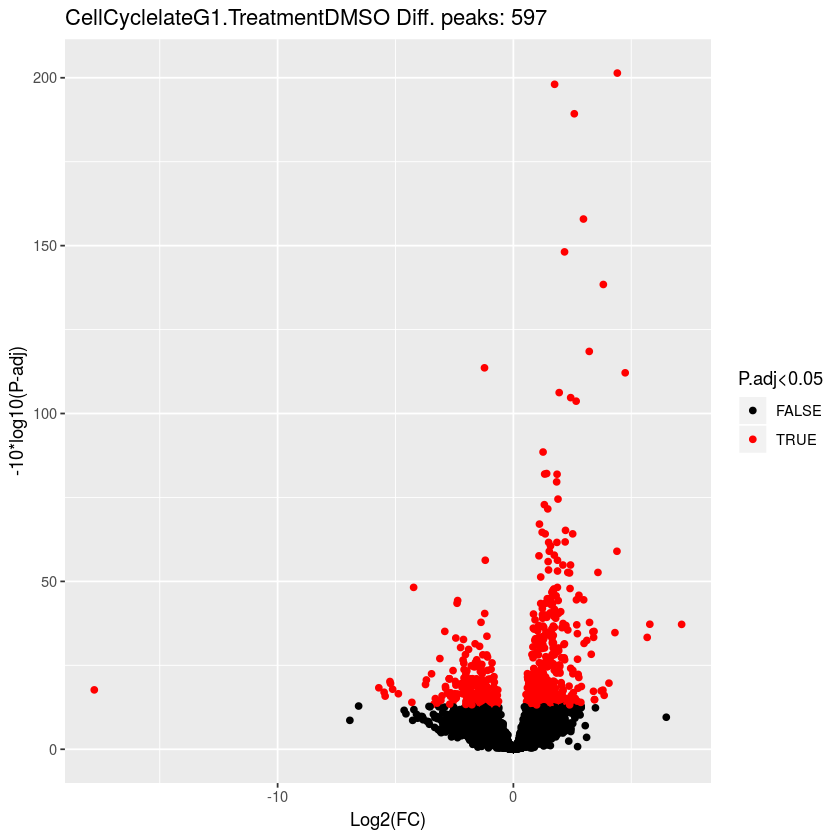

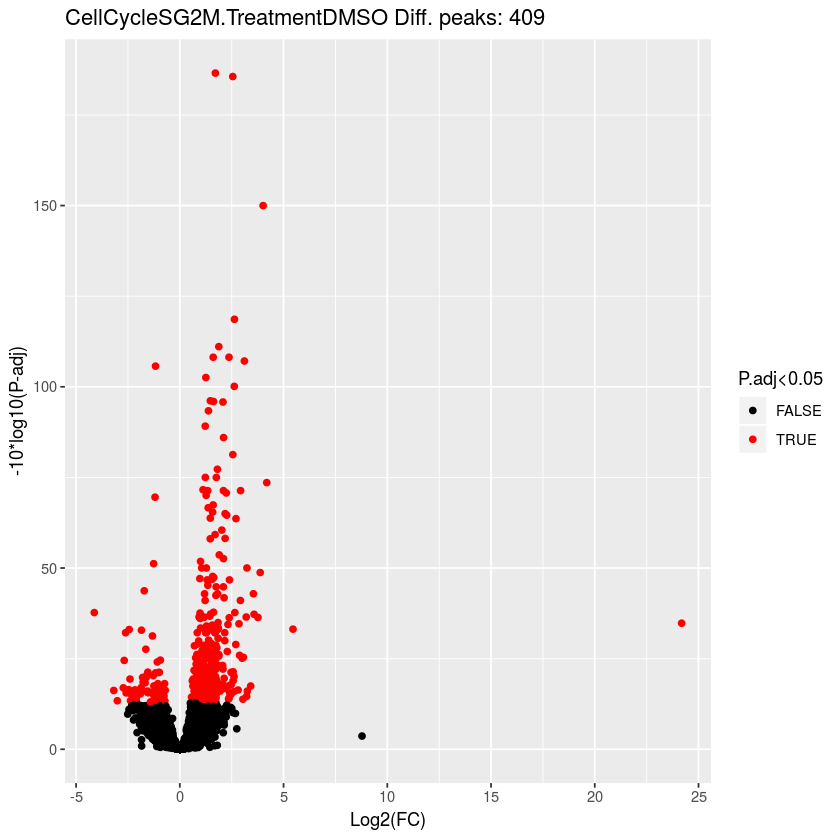

In [20]:
for(i in seq(1,numcomparisons))
{
 res=results(dds,name=namesToOutput[i],parallel=TRUE)
 res$logPadj=-10*log10(res$padj)
 res=as.data.frame(res)
 res=na.omit(res)
 numsig=sum(res$padj <= 0.05)
 sigsubset=res[res$padj<=0.05,]

 #output differential analysis results for the contrast
 #outtable=paste(namesToOutput[i],"tsv",sep='.')
 #write.table(sigsubset,file=outtable,quote=FALSE,sep='\t',row.names=TRUE,col.names=TRUE)
 #print(paste(namesToOutput[i],numsig))

 #generate a volcano plot of the differential analysis for the contrast
 #outpng=paste("volcano",namesToOutput[i],"png",sep='.')
 outlabel=paste(namesToOutput[i],"Diff. genes:",numsig)
 res$color=res$padj<=0.05

 #png(outpng)#,width=5,height=5,pointsize=12)
 print(ggplot(data=res,
        aes(x=res$log2FoldChange,
            y=res$logPadj,
            color=res$color))+
        geom_point()+
        xlab("Log2(FC)")+
        ylab("-10*log10(P-adj)")+
        ggtitle(outlabel)+
        scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05"))
 #dev.off()
}


## Find an Optimal Filtering Threshold with -log10Pval v baseMean

In [21]:
res=results(dds)
res$filtRatio=-log10(res$pvalue)/res$baseMean
res_df=as.data.frame(res[order(-res$filtRatio),])

Warning message:
“Removed 35353 rows containing missing values (geom_point).”

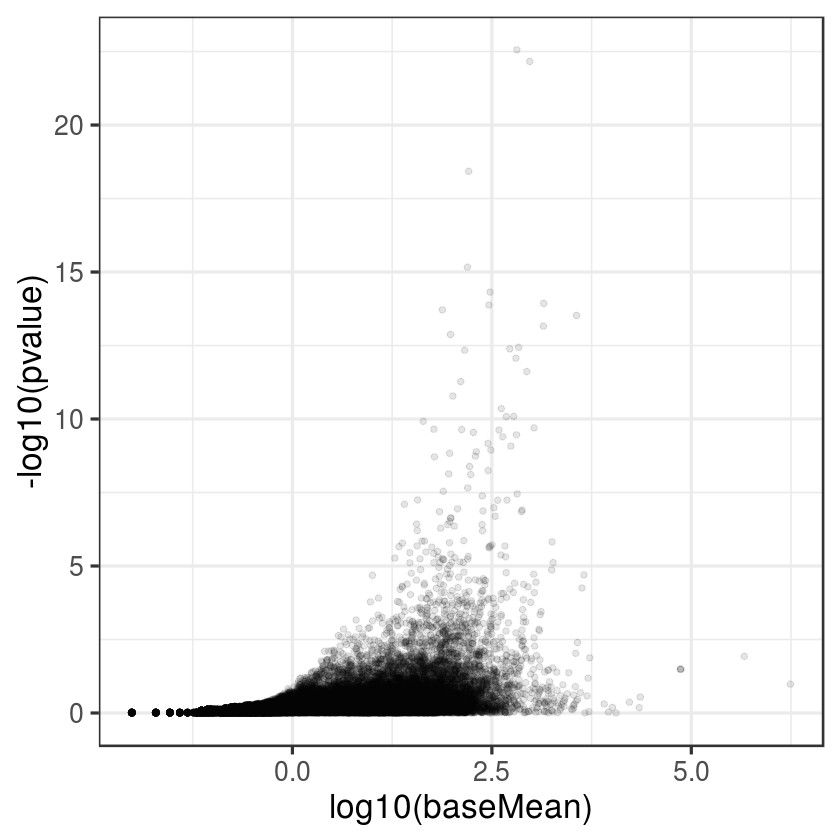

In [22]:
ggplot(data=res_df,
       aes(x=log10(res_df$baseMean),
           y=-log10(res_df$pvalue)))+
       geom_point(alpha=0.1)+
       xlab("log10(baseMean)")+
       ylab("-log10(pvalue)")+
       theme_bw(20)
       
       


## Find an optimal filtering threshold with IHW

In [23]:
library("IHW")
resIHW=results(dds,filterFun=ihw)
summary(resIHW)


out of 25322 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 475, 1.9%
LFC < 0 (down)     : 127, 0.5%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



In [24]:
sum(resIHW$padj < 0.1, na.rm=TRUE)



[1] 602

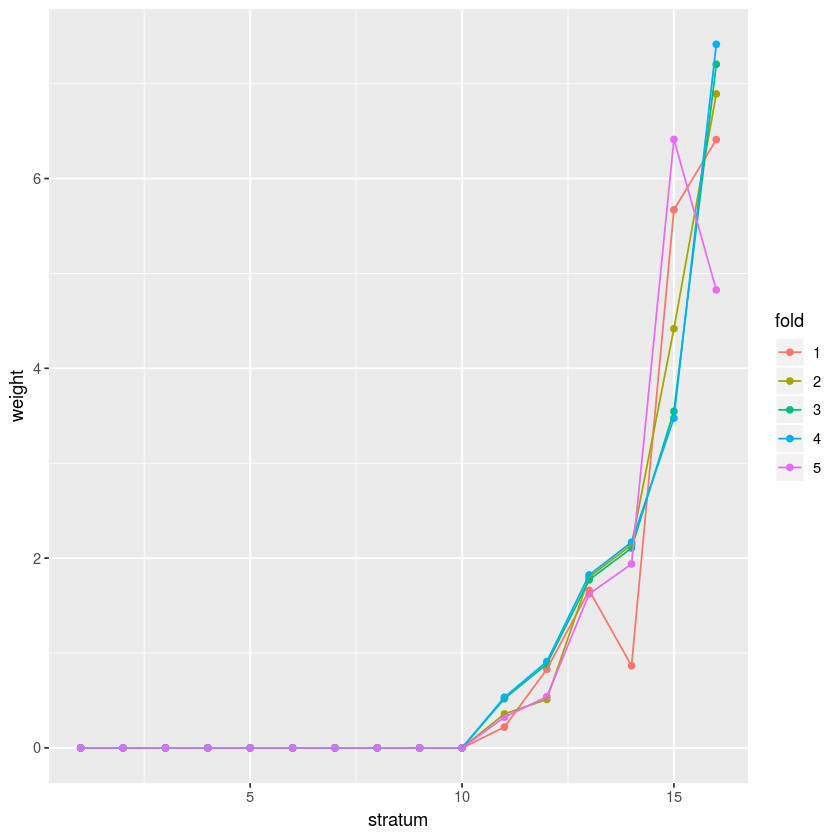

In [25]:
plot(metadata(resIHW)$ihwResult)



## Independent Filtering 

In [26]:
metadata(res)$alpha


[1] 0.1

In [27]:
metadata(res)$filterThreshold


86.75363% 
 13.03353

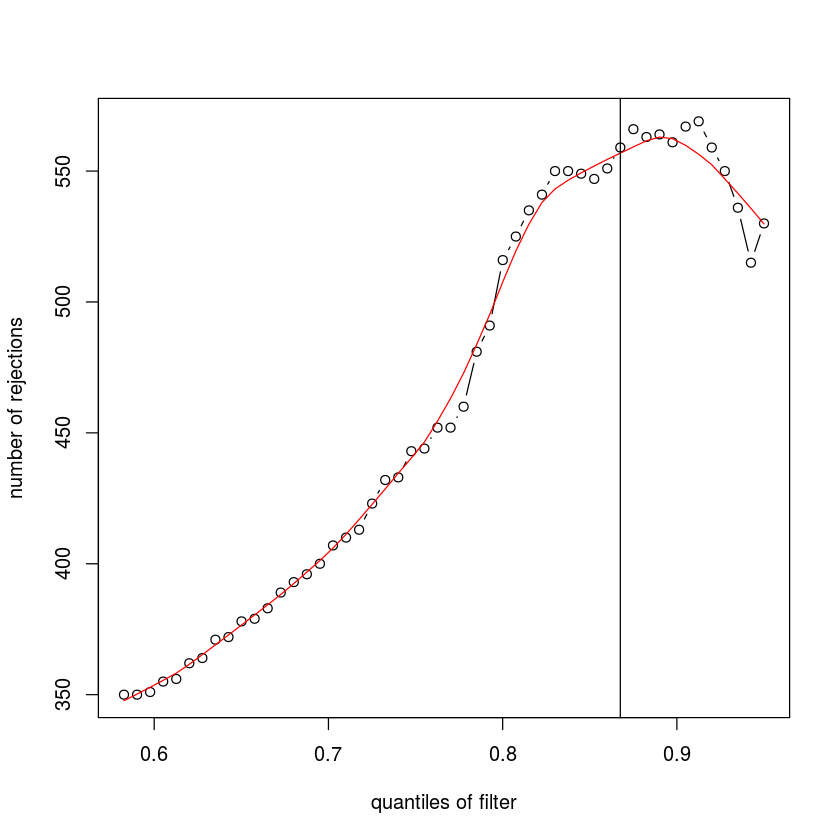

In [28]:
plot(metadata(res)$filterNumRej, 
     type="b", ylab="number of rejections",
     xlab="quantiles of filter")
lines(metadata(res)$lo.fit, col="red")
abline(v=metadata(res)$filterTheta)

In [29]:
resNoFilt <- results(dds, independentFiltering=FALSE)
addmargins(table(filtering=(res$padj < .1),
                 noFiltering=(resNoFilt$padj < .1)))

,FALSE,TRUE,Sum
FALSE,7479,0,7479
TRUE,219,340,559
Sum,7698,340,8038


In [30]:
summary(resNoFilt)


out of 25322 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 295, 1.2%
LFC < 0 (down)     : 55, 0.22%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## plotCounts for top5 genes -- QC 